# Algorithm explainer / figures

In [17]:
%matplotlib widget
import os
import pickle
import math
import zipfile
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
from IPython.display import Image, display
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import find_peaks
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gsp
import icelakes
from icelakes.utilities import encedc, decedc
from icelakes.nsidc import download_granule, edc
from icelakes.detection import read_atl03, detect_lakes, melt_lake

In [ ]:
'ATL03_20190716051841_02770403_005_01.h5'

In [2]:
# photon_data, bckgrd_data, ancillary = read_atl03(input_filename, geoid_h=True)

In [29]:
class dictobj:
    def __init__(self, in_dict:dict):
        assert isinstance(in_dict, dict)
        for key, val in in_dict.items():
            setattr(self, key, val)
                
    #-------------------------------------------------------------------------------------
    def plot_detected(self, fig_dir='figs', verbose=False, min_width=0.0, min_depth=0.0, print_mframe_info=True):

        import matplotlib
        from matplotlib.patches import Rectangle

        if len(self.detection_2nd_returns['h'])>0:
            lake_minh = np.min(self.detection_2nd_returns['h'])
        else: return
        lake_max_depth = np.abs(self.main_peak - np.min(self.detection_2nd_returns['h']))
        lake_segment_length = np.abs(np.max(self.detection_2nd_returns['xatc']) - np.min(self.detection_2nd_returns['xatc']))
        lake_maxh = np.min((self.mframe_data['peak'].max(), self.main_peak+0.5*lake_max_depth))
        buffer_bottom = np.max((0.5*lake_max_depth, 2.0))
        lake_minh_plot = lake_minh - buffer_bottom
        buffer_top = (lake_maxh - lake_minh_plot) * 0.5
        lake_maxh_plot = lake_maxh + buffer_top
        ylms = (lake_minh_plot, lake_maxh_plot)
        xlms = (0.0, self.mframe_data.xatc_max.max())

        if (lake_max_depth > min_depth) & (lake_segment_length > min_width):
            fig, ax = plt.subplots(figsize=[9, 5], dpi=100)

            # plot the ATL03 photon data
            scatt = ax.scatter(self.photon_data.xatc, self.photon_data.h,s=5, c=self.photon_data.snr, alpha=1, 
                               edgecolors='none', cmap=cmc.lajolla, vmin=0, vmax=1)
            p_scatt = ax.scatter([-9999]*4, [-9999]*4, s=15, c=[0.0,0.25,0.75,1.0], alpha=1, edgecolors='none', cmap=cmc.lajolla, 
                                 vmin=0, vmax=1, label='ATL03 photons')

            # plot surface elevation
            for xtent in self.surface_extent_detection:
                ax.plot(xtent, [self.surface_elevation, self.surface_elevation], 'g-', lw=3)
            p_surf_elev, = ax.plot([-9999]*2, [-9999]*2, 'g-', lw=3, label='lake surface')

            # plot the second returns from detection
            for j, prom in enumerate(self.detection_2nd_returns['prom']):
                ax.plot(self.detection_2nd_returns['xatc'][j], self.detection_2nd_returns['h'][j], 
                                        marker='o', mfc='none', mec='b', linestyle = 'None', ms=prom*8)
            p_2nd_return, = ax.plot(-9999, -9999, marker='o', mfc='none', mec='b', ls='None', ms=3, label='second returns')

            # plot mframe bounds
            ymin, ymax = ax.get_ylim()
            mframe_bounds_xatc = list(self.mframe_data['xatc_min']) + [self.mframe_data['xatc_max'].iloc[-1]]
            for xmframe in mframe_bounds_xatc:
                ax.plot([xmframe, xmframe], [ymin, ymax], 'k-', lw=0.5)

            # visualize which segments initially passed
            for i, passing in enumerate(self.mframe_data['lake_qual_pass']):
                mf = self.mframe_data.iloc[i]
                if passing:
                    xy = (mf.xatc_min, ylms[0])
                    width = mf.xatc_max - mf.xatc_min
                    height = ylms[1] - ylms[0]
                    rct = Rectangle(xy, width, height, ec=(1,1,1,0), fc=(0,0,1,0.1), zorder=-1000, label='major frame passed lake check')
                    p_passed = ax.add_patch(rct)
                p_mfpeak, = ax.plot((mf.xatc_min,mf.xatc_max), (mf.peak,mf.peak),'k-',lw=0.5, label='major frame peak')

            # add a legend
            hdls = [p_scatt, p_surf_elev, p_2nd_return, p_mfpeak, p_passed]
            ax.legend(handles=hdls, loc='lower left', fontsize=7, scatterpoints=4)

            # add the colorbar 
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='4%', pad=0.05)
            cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
            cbar.ax.get_yaxis().set_ticks([])
            for j, lab in enumerate([0.2, 0.4, 0.6, 0.8]):
                cbar.ax.text(.5, lab, '%.1f'%lab, ha='center', va='center', fontweight='black')
            cbar.ax.get_yaxis().labelpad = 15
            cbar.ax.set_ylabel('photon density', rotation=270, fontsize=8)

            # add labels and description in title
            txt  = 'ICESat-2 Lake Detection: %s, ' % ('Greenland Ice Sheet' if self.lat>=0 else 'Antarctic Ice Sheet')
            txt += '%s Melt Season' % self.melt_season
            fig.suptitle(txt, y=0.95, fontsize=14)

            txt  = 'location: %s, %s (area: %s) | ' % (self.lat_str, self.lon_str, self.polygon_name)
            txt += 'time: %s UTC | surface elevation: %.2f m\n' % (self.date_time, self.surface_elevation)
            txt += 'RGT %s %s cycle %i | ' % (self.rgt, self.gtx.upper(), self.cycle_number)
            txt += 'beam %i (%s, %s spacecraft orientation) | ' % (self.beam_number, self.beam_strength, self.sc_orient)
            txt += 'granule ID: %s' % self.granule_id
            ax.set_title(txt, fontsize=8)

            ax.set_ylabel('elevation above geoid [m]',fontsize=8)
            ax.tick_params(axis='x', which='major', labelsize=7)
            ax.tick_params(axis='y', which='major', labelsize=6)
            # set limits
            ax.set_ylim(ylms)
            ax.set_xlim(xlms)

            # add latitude
            #_________________________________________________________
            lx = self.photon_data.sort_values(by='lat').iloc[[0,-1]][['lat','xatc']].reset_index(drop=True)
            lat = np.array(lx.lat)
            xatc = np.array(lx.xatc)
            def forward(x):
                return lat[0] + x * (lat[1] - lat[0]) / (xatc[1] - xatc[0])
            def inverse(l):
                return xatc[0] + l * (xatc[1] - xatc[0]) / (lat[1] - lat[0])
            secax = ax.secondary_xaxis(-0.065, functions=(forward, inverse))
            secax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
            secax.set_xlabel('latitude / along-track distance',fontsize=8,labelpad=0)
            secax.tick_params(axis='both', which='major', labelsize=7)
            secax.ticklabel_format(useOffset=False) # show actual readable latitude values

            # rename x ticks
            xticklabs = ['%g km' % (xt/1000) for xt in list(ax.get_xticks())]
            ticks = ax.get_xticks()
            ax.set_xticks(ticks)
            ax.set_xticklabels(xticklabs)

            # add mframe info text
            if print_mframe_info:
                txt  = 'mframe:\n' % (mf.name%1000)
                txt += 'photons:\n' % mf.n_phot
                txt += 'peak:\n'
                txt += 'flat:\n'
                txt += 'SNR surf:\n'
                txt += 'SNR up:\n'
                txt += 'SNR low:\n'
                txt += '2nds:\n'
                txt += '2nds strength:\n'
                txt += '2nds number:\n'
                txt += '2nds spread:\n'
                txt += '2nds align:\n'
                txt += '2nds quality:\n'
                txt += 'pass:'
                # trans = ax.get_xaxis_transform()
                bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
                ax.text(-0.005, 0.98, txt, transform=ax.transAxes, fontsize=4, ha='right', va='top', bbox=bbox)
                for i,loc in enumerate(self.mframe_data['xatc']):
                    mf = self.mframe_data.iloc[i]
                    txt  = '%i\n' % (mf.name%1000)
                    txt += '%i\n' % mf.n_phot
                    txt += '%.2f\n' % mf.peak
                    txt += '%s\n' % ('Yes.' if mf.is_flat else 'No.')
                    txt += '%i\n' % np.round(mf.snr_surf)
                    txt += '%i\n' % np.round(mf.snr_upper)
                    txt += '%i\n' % np.round(mf.snr_lower)
                    txt += '%i%%\n' % np.round(mf.ratio_2nd_returns*100)
                    txt += '%.2f\n' % mf.quality_secondreturns
                    txt += '%.2f\n' % mf.length_penalty
                    txt += '%.2f\n' % mf.range_penalty
                    txt += '%.2f\n' % mf.alignment_penalty
                    txt += '%.2f\n' % mf.quality_summary
                    txt += '%s' % ('Yes.' if mf.lake_qual_pass else 'No.')
                    trans = ax.get_xaxis_transform()
                    bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
                    ax.text(loc, 0.98, txt, transform=trans, fontsize=4,ha='center', va='top', bbox=bbox)

            # add detection quality description
            txt  = 'LAKE QUALITY: %6.4f'%self.detection_quality
            txt += '\n---------------------------\n'
            txt += '2nd returns: %6.4f\n' % self.detection_quality_info['strength_2nd_returns']
            txt += 'alignment: %6.4f\n' % self.detection_quality_info['qual_alignment']
            txt += 'depth: %6.4f\n' % self.detection_quality_info['lake_depth']
            txt += 'length: %6.4f\n' % self.detection_quality_info['lake_length']
            txt += 'depth range: %6.4f' % self.detection_quality_info['h_range_2nd_returns']
            bbox = {'fc':(1,1,1,0.75), 'ec':(1,1,1,0), 'pad':1}
            ax.text(0.99, 0.02, txt, transform=ax.transAxes, ha='right', va='bottom',fontsize=6, weight='bold', bbox=bbox)

            fig.patch.set_facecolor('white')
            fig.tight_layout()
            ax.set_ylim(ylms)
            ax.set_xlim(xlms)

            # save figure
            if not os.path.exists(fig_dir): os.makedirs(fig_dir)
            epoch = self.mframe_data['dt'].mean() + datetime.datetime.timestamp(datetime.datetime(2018,1,1))
            dateid = datetime.datetime.fromtimestamp(epoch).strftime("%Y%m%d-%H%M%S")
            granid = self.granule_id[:-3]
            latid = '%dN'%(int(np.round(self.lat*1e5))) if self.lat>=0 else '%dS'%(-int(np.round(self.lat*1e5)))
            lonid = '%dE'%(int(np.round(self.lon*1e5))) if self.lon>=0 else '%dW'%(-int(np.round(self.lon*1e5)))

            plt.close(fig)

            return fig
                
searchfor = 'lake_'
filelist = ['pickles/'+f for f in os.listdir('pickles') \
            if os.path.isfile(os.path.join('pickles', f)) & (searchfor in f)]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

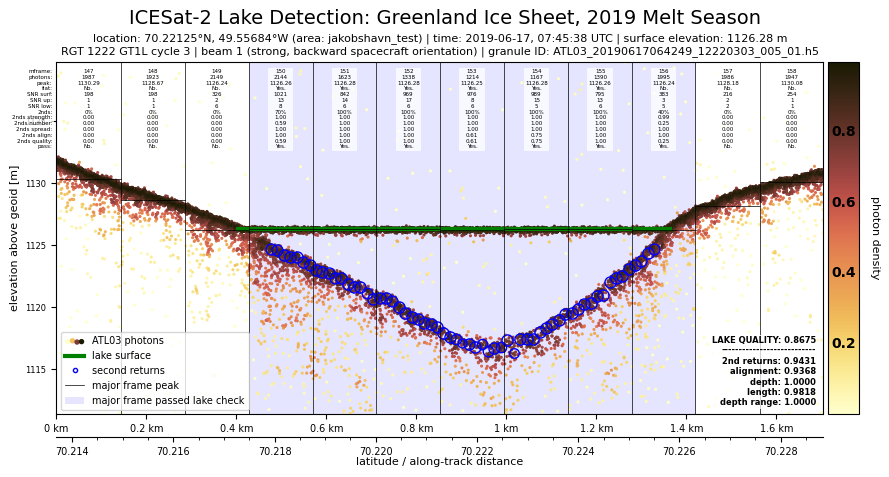

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

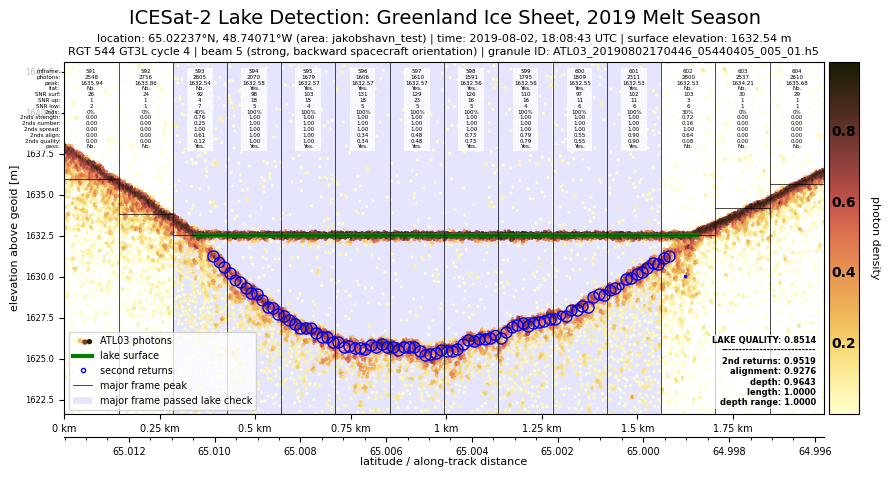

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

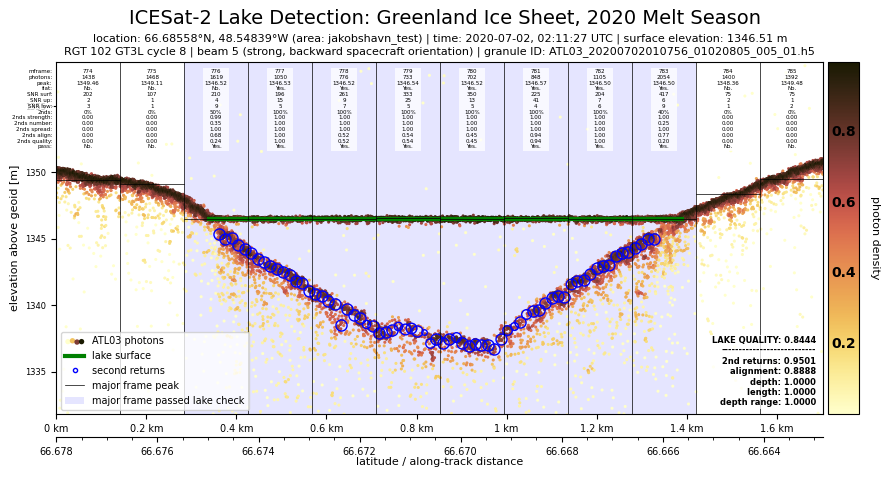

CPU times: user 4.04 s, sys: 111 ms, total: 4.15 s
Wall time: 1.8 s


In [30]:
%%time
lake_list = []
for filename in sorted(filelist)[:3]:
    with open(filename, 'rb') as f:
        lk_dict = pickle.load(f)
        lk = dictobj(lk_dict)
        fig = lk.plot_detected(print_mframe_info=True)
        display(fig)
#         figname = 'figs_detection_info/' + filename[filename.rfind('/')+1:].replace('.pkl','.jpg')
#         print(figname)
#         fig.savefig(figname, dpi=300, bbox_inches='tight', pad_inches=0)

# for dirtozip in ['figs_detection_info']:
#     filelist = [dirtozip+'/'+f for f in os.listdir(dirtozip) if os.path.isfile(os.path.join(dirtozip+'/', f))]
#     ZipFile = zipfile.ZipFile("zip_test_%s.zip"%dirtozip, "w" )
#     for file in filelist:
#         ZipFile.write(file, compress_type=zipfile.ZIP_DEFLATED)
#     ZipFile.close()

In [ ]:
sorted(filelist)[:5]